# Model Fitting: SGD

import numpy as np
import scipy.stats
import scipy.optimize
import pandas as pd
import pickle
import random

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import pandas as pd
import pickle
import random
import scipy.optimize

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.scipy.stats import norm

## Data Manipulation

In [2]:
player_info = pd.read_csv("clean-data/player_info.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [3]:
player_info.head()

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
0,Kobe Bryant,Los Angeles Lakers,25000000,SF,37,66,66,1863,10.7,30.0,...,5.6,6.7,5.0,1.7,0.4,3.5,3.1,31.3,95.0,113.0
1,Joe Johnson,Brooklyn Nets,24894863,SF,34,81,81,2703,7.1,16.1,...,4.6,5.5,6.0,1.1,0.1,3.0,2.7,18.6,104.0,113.0
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,2709,14.0,26.9,...,8.6,10.7,9.8,2.0,0.9,4.7,2.7,36.5,116.0,103.0
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,2530,11.5,26.6,...,9.3,11.3,6.1,1.3,0.8,3.6,3.7,32.0,107.0,107.0
4,Dwight Howard,Houston Rockets,22359364,C,30,71,71,2280,8.0,12.9,...,12.9,18.0,2.1,1.5,2.4,3.6,4.7,21.0,111.0,104.0


In [4]:
game_outcomes.head()

,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Year,diff,Visitor_Index,Home_Index
0,Detroit Pistons,106.0,Atlanta Hawks,94.0,2016,12.0,5,26
1,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,2016,-2.0,25,11
2,New Orleans Pelicans,95.0,Golden State Warriors,111.0,2016,-16.0,24,10
3,Philadelphia 76ers,95.0,Boston Celtics,112.0,2016,-17.0,4,6
4,Chicago Bulls,115.0,Brooklyn Nets,100.0,2016,15.0,11,27


Make indices for home/visitor

In [5]:
guest_matrix = np.zeros((game_outcomes.shape[0], np.max(game_outcomes['Visitor_Index']) + 1), dtype = bool)
guest_matrix.shape
host_matrix = np.copy(guest_matrix)

def make_matrix(mat, indices):
    for (i, ind) in enumerate(indices):
        mat[i, ind] = True


make_matrix(host_matrix, game_outcomes['Visitor_Index'].values)
make_matrix(guest_matrix, game_outcomes['Home_Index'].values)

Read the player info

In [6]:
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)

In [7]:
off_rating = player_info['PTS'].values
def_rating = player_info['DRtg'].values

In [8]:
player_info[player_info['ORtg'] > 130]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
248,Joel Anthony,Detroit Pistons,2500000,C,33,19,0,96,3.2,5.3,...,6.8,11.0,0.5,1.1,6.3,1.1,7.9,9.5,136.0,99.0
373,Rakeem Christmas,Indiana Pacers,1000000,PF,24,1,0,6,16.6,16.6,...,0.0,8.3,0.0,0.0,0.0,0.0,8.3,33.1,204.0,112.0
406,Jarnell Stokes,New Orleans Pelicans,845059,C,22,7,0,18,8.6,14.3,...,8.6,11.4,2.9,2.9,0.0,0.0,2.9,20.0,131.0,103.0


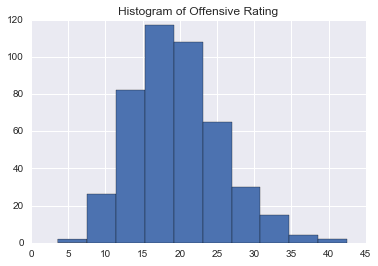

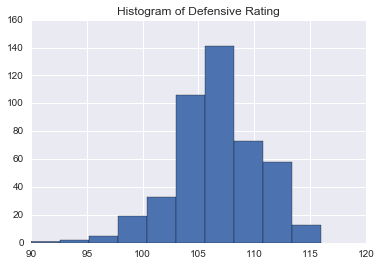

In [9]:
plt.hist(off_rating)
plt.title("Histogram of Offensive Rating")
plt.show()

plt.hist(def_rating)
plt.title("Histogram of Defensive Rating")
plt.show()

In [10]:
game_diff = game_outcomes['diff'].values

## Stochastic Gradient Descent

In [11]:
test_x = np.array([1,2,3,4])
test_b = np.array([4, 5, 6, 7])
mask = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0]])
print(mask)
print(test_x * test_b)
print(np.dot(mask, test_x * test_b))

[[0 1 0 1]
 [1 0 1 0]
 [1 1 0 0]]
[ 4 10 18 28]
[38 22 14]


In [12]:
host_lineup_arr = np.array(host_team_line_up)
guest_lineup_arr = np.array(guest_team_line_up)
nplayers = player_info.shape[0]
nteams = host_matrix.shape[1]
print("Number of players: %d. Number of teams: %d." %(nplayers, nteams))

Number of players: 451. Number of teams: 30.


In [13]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams) + 1,))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):-1]
    
    # parameterize sigma by its log
    logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    
    return (beta0, beta_player, gamma0, gamma_player, logsigma)

In [14]:
coefs = np.random.randn(2*(nplayers + nteams) + 1)
b0, bs, g0, gs, logsig = split_params(coefs, nplayers, nteams)

In [137]:
def negloglik(coefs, game_diff, off_rating, def_rating, nplayers, nteams,
           guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr,
           lam = 0):
    beta0, betas, gamma0, gammas, logsigma = \
            split_params(coefs, nplayers, nteams)
    
    ngames = game_diff.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = np.sum(norm.logpdf(game_diff, mean, np.exp(logsigma)))
    loglik -= lam * np.linalg.norm(coefs[:-1])
    return(-loglik)

In [138]:
negloglik_grad = grad(negloglik)

In [139]:
negloglik(coefs, game_diff, off_rating, def_rating, nplayers, nteams,
       guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr)

156407318.26446047

In [168]:
extra_args = (game_diff, off_rating, def_rating, nplayers,
              nteams, guest_matrix, host_matrix,
              guest_lineup_arr, host_lineup_arr)

opt_res = scipy.optimize.minimize(negloglik, coefs, extra_args,
                       jac = negloglik_grad, method = "L-BFGS-B")

In [169]:
print(opt_res.success)

True


In [170]:
best_coefs = opt_res.x

Check the standard deviation

In [171]:
np.exp(best_coefs[-1])

11.661885469507695

In [172]:
best_beta0, best_beta, best_gamma0, best_gamma, best_logsigma = split_params(best_coefs, nplayers, nteams)

In [175]:
contribute_off = np.argsort(-best_beta)# * player_info['PTS'])
betas_df = player_info.loc[contribute_off]
betas_df['beta'] = best_beta[contribute_off]
betas_df.head(10)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,beta
374,Montrezl Harrell,Houston Rockets,1000000,PF,22,39,1,379,7.5,11.7,...,8.4,2.2,1.4,1.4,2.2,6.2,18.2,119.0,110.0,3.239532
213,Emmanuel Mudiay,Denver Nuggets,3102240,PG,19,68,66,2068,8.0,21.9,...,5.6,9.0,1.6,0.8,5.3,3.4,21.1,88.0,110.0,2.595466
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,2709,14.0,26.9,...,10.7,9.8,2.0,0.9,4.7,2.7,36.5,116.0,103.0,2.485088
249,Terrence Jones,Houston Rockets,2489530,PF,24,50,11,1044,7.8,17.3,...,9.9,1.9,1.1,1.8,2.3,4.1,20.4,104.0,109.0,2.053269
122,Jodie Meeks,Detroit Pistons,6270000,SG,28,3,0,43,8.2,23.5,...,5.9,3.5,0.0,0.0,1.2,2.3,25.8,111.0,111.0,2.028495
126,Andrew Wiggins,Minnesota Timberwolves,5758680,SF,20,81,81,2845,10.5,22.9,...,5.2,2.9,1.4,0.8,3.2,2.9,29.7,106.0,113.0,1.902087
297,Jerian Grant,New York Knicks,1572360,PG,23,76,6,1265,6.3,15.9,...,5.8,7.2,2.0,0.4,3.5,3.9,17.3,97.0,108.0,1.897880
312,Jason Terry,Houston Rockets,1499187,SG,38,72,7,1258,5.9,14.7,...,3.1,4.0,1.8,0.4,1.9,3.6,16.5,108.0,112.0,1.874786
400,JaKarr Sampson,Philadelphia 76ers,845059,SF,22,73,40,1160,6.0,13.5,...,8.1,2.0,1.0,1.4,3.0,6.1,15.9,94.0,110.0,1.829379
384,Justin Holiday,Chicago Bulls,947300,SG,26,53,5,773,5.7,14.7,...,5.8,3.6,2.1,1.2,2.5,3.9,15.4,94.0,105.0,1.812983


## Doesn't work right now

In [152]:
def loglik_i(coefs, i, game_diff, off_rating, def_rating, nplayers, nteams,
           guest_matrix, host_matrix, guest_lineup_arr, host_lineup_arr,
           lam = 0):
    beta0, betas, gamma0, gammas, logsigma = \
            split_params(coefs, nplayers, nteams)
    
    ngames = game_diff.shape[0]
    
    guest_off_0 = np.dot(guest_matrix[i], beta0)
    guest_def_0 = np.dot(guest_matrix[i], gamma0)
    host_off_0 = np.dot(host_matrix[i], beta0)
    host_def_0 = np.dot(host_matrix[i], gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr[i], betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr[i], gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr[i], betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr[i], gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = np.sum(norm.logpdf(game_diff[i], mean, 15))
    loglik -= lam * np.linalg.norm(coefs[:-1])
    return(loglik)

In [153]:
loglik_i(coefs, range(1230), *extra_args)

-1124379.1317307521

In [154]:
loglik_i_grad = grad(loglik_i)

In [155]:
sgd_coefs = np.random.randn(2*(nplayers + nteams) + 1)
sgd_coefs[-1] = -10
sgd_coefs

array([ -5.28757308e-01,   3.03410484e-01,  -8.13853473e-02,
         4.66858866e-01,   5.11706505e-01,  -1.64284945e+00,
         1.76793570e+00,   1.04836375e+00,  -4.84483945e-01,
        -1.61891890e+00,  -1.49647485e+00,  -1.13141335e+00,
        -5.57496408e-01,   3.50357245e-01,  -1.39607501e-01,
        -1.32710272e-01,  -2.57882129e+00,   1.14570915e+00,
        -1.28270157e-01,   2.68369816e-01,   6.16963126e-01,
         7.04869811e-01,   2.55016154e-01,  -1.19044866e+00,
        -4.41167199e-01,   1.28806684e-01,  -1.86635497e-01,
        -1.34369803e+00,  -1.73661239e-01,  -1.63790339e+00,
        -5.13482260e-01,   2.24576881e+00,   2.11321019e-01,
         6.64626271e-01,  -1.87193294e+00,  -4.03090690e-01,
        -4.21019251e-01,   2.59235612e-01,   1.50360162e-01,
         2.15537117e-01,   7.31786804e-01,   8.39726739e-01,
        -1.12779998e+00,  -7.34916678e-01,  -1.90712182e+00,
        -1.38454264e+00,  -1.07369184e+00,   2.55862236e+00,
        -5.72425387e-01,

In [156]:
loglik_i_grad(sgd_coefs, 0, *extra_args)

array([  1.71019347e-02,  -9.81339873e-03,   2.63229817e-03,
        -1.50999139e-02,  -1.65504497e-02,  -4.70477176e+00,
        -5.71814714e-02,  -3.39078972e-02,   1.56699731e-02,
         5.23617260e-02,   4.84014400e-02,   3.65940234e-02,
         1.80314617e-02,  -1.13318277e-02,   4.51541442e-03,
         4.29233293e-03,   8.34084610e-02,  -3.70564016e-02,
         4.14872348e-03,  -8.68005607e-03,  -1.99548317e-02,
        -2.27980537e-02,  -8.24815006e-03,   3.85034399e-02,
         1.42689520e-02,  -4.16607670e-03,   4.76394396e+00,
         4.34600820e-02,   5.61683616e-03,   5.29757537e-02,
         1.66078841e-02,  -7.26363323e-02,  -6.83489044e-03,
        -2.14964312e-02,   6.05451206e-02,   1.30374192e-02,
         1.36172941e-02,  -8.38462269e-03,  -4.86319457e-03,
        -6.97125438e-03,  -2.36686472e-02,  -2.71598173e-02,
         3.64771537e-02,   2.37698787e-02,   6.16832570e-02,
        -1.23185023e+02,   3.47270997e-02,  -8.27551543e-02,
         1.85143193e-02,

In [163]:
# copied from: https://github.com/HIPS/autograd/blob/master/examples/optimizers.py
def sgd(grad, x, callback=None, num_iters=200, step_size=0.1, mass=0.9, args=()):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
    velocity = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i, *args)
        if callback: callback(x, i, g)
        velocity = mass * velocity - (1.0 - mass) * g
        x -= step_size * velocity
    return x

In [164]:
sgd_coefs = np.random.randn(2*(nplayers + nteams) + 1)
sgd_coefs[-1] = -10
def callback(x, i, g):
    print("iteration: %d" %i)
    print("Likelihood: %f" %(negloglik(x, *extra_args)))
    #print("%f, %f" %(x[-1], g[-1]))
    #print("Gradient:")
    #print(g)

sgd_coefs = sgd(loglik_i_grad, sgd_coefs, callback=callback, step_size = 0.0001,
                num_iters = 40, args = extra_args)

iteration: 0
Likelihood: 120292051502539104.000000
iteration: 1
Likelihood: 120251047537853216.000000
iteration: 2
Likelihood: 120074971835571392.000000
iteration: 3
Likelihood: 119904415638727136.000000
iteration: 4
Likelihood: 119737319493604208.000000
iteration: 5
Likelihood: 119035946023532496.000000
iteration: 6
Likelihood: 118409862660742512.000000
iteration: 7
Likelihood: 117855251786226752.000000
iteration: 8
Likelihood: 117268918258097392.000000
iteration: 9
Likelihood: 116747746942988384.000000
iteration: 10
Likelihood: 116281932283273216.000000
iteration: 11
Likelihood: 115806072904955040.000000
iteration: 12
Likelihood: 115193108377351072.000000
iteration: 13
Likelihood: 114626540385562080.000000
iteration: 14
Likelihood: 114119515517693472.000000
iteration: 15
Likelihood: 113657650149073136.000000
iteration: 16
Likelihood: 113212640165766400.000000
iteration: 17
Likelihood: 112545391635629312.000000
iteration: 18
Likelihood: 111729765824264736.000000
iteration: 19
Likeliho

In [132]:
sgd_coefs[-1]

nan

In [13]:
nplayers = player_info.shape[0]
coefs = sgd(game_diff, off_rating, def_rating, nplayers, random_state=0,
            nbatches = 30, learning_rate=1e-6, lam = 1)
betas = coefs[:nplayers]
gammas = coefs[nplayers:]

Neg Log likelihood at batch 0: 18826282.562989
Neg Log likelihood at batch 1: 4436190.380787
Neg Log likelihood at batch 2: 2038521.617819
Neg Log likelihood at batch 3: 1595285.973383
Neg Log likelihood at batch 4: 1529077.222991
Neg Log likelihood at batch 5: 1519952.825712
Neg Log likelihood at batch 6: 1522016.080473
Neg Log likelihood at batch 7: 1522183.362951
Neg Log likelihood at batch 8: 1522807.122151
Neg Log likelihood at batch 9: 1522727.871941
Neg Log likelihood at batch 10: 1525181.939009
Neg Log likelihood at batch 11: 1523231.059113
Neg Log likelihood at batch 12: 1520544.514997
Neg Log likelihood at batch 13: 1521454.222358
Neg Log likelihood at batch 14: 1523022.035150
Neg Log likelihood at batch 15: 1523432.645865
Neg Log likelihood at batch 16: 1520784.620703
Neg Log likelihood at batch 17: 1519190.098445
Neg Log likelihood at batch 18: 1522536.768124
Neg Log likelihood at batch 19: 1521748.677883
Neg Log likelihood at batch 20: 1522213.145222
Neg Log likelihood at 

In [14]:
contribute_off = np.argsort(-betas)# * player_info['PTS'])
betas_df = player_info.loc[contribute_off]
betas_df['beta'] = betas[contribute_off]
betas_df.head(10)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,beta
327,Gerald Green,Miami Heat,1356000,SG,30,69,14,1557,7.6,19.3,...,5.4,1.8,1.3,0.6,1.5,4.1,20.3,99.0,107.0,2.409070
144,Victor Oladipo,Orlando Magic,5192520,SG,23,72,52,2379,8.9,20.4,...,7.3,5.9,2.4,1.1,3.2,3.7,24.2,105.0,106.0,2.394966
292,Tyler Ennis,Milwaukee Bucks,1662360,PG,21,46,7,654,6.5,14.6,...,5.8,7.4,1.9,0.1,3.6,5.0,16.0,99.0,111.0,2.322091
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,2530,11.5,26.6,...,11.3,6.1,1.3,0.8,3.6,3.7,32.0,107.0,107.0,2.311427
218,Tibor Pleiss,Utah Jazz,3000000,C,26,12,0,82,7.1,16.1,...,9.6,1.3,0.6,1.3,5.1,12.2,15.4,82.0,106.0,2.239915
24,John Wall,Washington Wizards,15851950,PG,25,77,77,2784,10.0,23.6,...,6.6,13.8,2.5,1.0,5.6,2.8,26.8,102.0,104.0,2.175118
198,Nerlens Noel,Philadelphia 76ers,3457800,C,21,67,62,1965,7.6,14.6,...,13.5,3.0,2.9,2.5,3.9,4.8,18.6,99.0,103.0,2.173362
105,Anthony Davis,New Orleans Pelicans,7070730,PF,22,61,61,2164,12.8,26.0,...,14.4,2.7,1.8,2.9,2.8,3.4,33.9,110.0,104.0,2.068762
279,Aaron Brooks,Chicago Bulls,2000000,PG,31,69,0,1108,8.5,21.2,...,4.6,8.1,1.4,0.5,3.7,6.0,22.2,99.0,109.0,1.994963
108,Ed Davis,Portland Trail Blazers,7000000,PF,26,81,0,1684,6.1,10.0,...,17.8,2.6,1.7,2.1,1.9,6.0,15.6,128.0,104.0,1.961833


In [15]:
betas_df[betas_df['Tm'] == "Golden State Warriors"]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,beta
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,2666,11.8,25.1,...,5.5,3.0,1.1,0.9,2.5,2.8,32.1,112.0,107.0,1.449484
37,Draymond Green,Golden State Warriors,14300000,PF,25,81,81,2808,6.9,14.1,...,13.2,10.3,2.1,1.9,4.5,4.1,19.5,115.0,100.0,1.151780
247,Leandro Barbosa,Golden State Warriors,2500000,SG,33,68,0,1079,7.7,16.6,...,5.2,3.7,2.0,0.4,2.4,4.8,19.4,106.0,106.0,1.029278
415,James Michael McAdoo,Golden State Warriors,845059,PF,23,41,1,262,8.3,15.5,...,10.7,3.1,1.8,1.5,3.0,7.2,21.6,112.0,104.0,0.628452
118,Jason Thompson,Golden State Warriors,6431250,C,29,47,7,471,5.6,11.5,...,14.3,3.1,1.3,2.1,1.6,8.6,15.7,119.0,102.0,0.573340
64,Stephen Curry,Golden State Warriors,11370786,PG,27,79,79,2700,14.4,28.6,...,7.7,9.4,3.0,0.3,4.7,2.9,42.5,125.0,103.0,0.067144
187,Marreese Speights,Golden State Warriors,3815000,C,28,72,0,832,11.4,26.5,...,13.9,3.5,1.1,2.0,3.8,6.8,29.7,102.0,103.0,-0.024903
277,Festus Ezeli,Golden State Warriors,2008748,C,26,46,13,770,7.8,14.3,...,16.1,2.0,1.1,3.1,2.4,5.9,20.1,114.0,101.0,-0.168261
392,Ian Clark,Golden State Warriors,947276,SG,24,66,1,578,7.4,16.9,...,5.7,5.4,1.4,1.1,3.6,4.8,19.7,102.0,106.0,-0.404551
357,Kevon Looney,Golden State Warriors,1131960,PF,19,5,0,21,9.2,16.1,...,23.0,0.0,0.0,0.0,2.3,4.6,20.7,125.0,105.0,-0.531688


## Using L-BFGS

In [16]:
def grad_neg_log(coefs, game_diff, off_rating, def_rating, nplayers, lam = 0, sigma_sq = 0.01):
    betas = coefs[:nplayers]
    gammas = coefs[nplayers:]
    ngames = game_diff.shape[0]
    
    grad_coefs = np.zeros_like(coefs)
    
    for i in xrange(ngames):
        host_lineup = host_team_line_up[i]
        guest_lineup = guest_team_line_up[i]

        host_betas = betas[host_lineup]
        host_gammas = gammas[host_lineup]

        host_off = off_rating[host_lineup]
        host_def = def_rating[host_lineup]

        guest_betas = betas[guest_lineup]
        guest_gammas = gammas[guest_lineup]

        guest_off = off_rating[guest_lineup]
        guest_def = def_rating[guest_lineup]

        common_part = (1.0/(sigma_sq)) * (game_diff[i] - np.dot(guest_off, guest_betas)
                                            - np.dot(host_def, host_gammas)
                                            - np.dot(host_off, host_betas)
                                            + np.dot(guest_def, guest_gammas))
        #guest_betas -= -learning_rate * guest_off * common_part + 2 * lam * guest_betas
        grad_coefs[:nplayers][guest_lineup] += -guest_off * common_part + 2 * lam * guest_betas
        #host_betas -= learning_rate * host_off * common_part + 2 * lam * host_betas
        grad_coefs[:nplayers][host_lineup] += host_off * common_part + 2 * lam * host_betas
        #guest_gammas -= -learning_rate * guest_def * common_part + 2 * lam * guest_gammas
        grad_coefs[nplayers:][guest_lineup] += -guest_def * common_part + 2 * lam * guest_gammas
        #host_gammas -= learning_rate * host_def * common_part + 2 * lam * host_gammas
        grad_coefs[nplayers:][host_lineup] += host_def * common_part + 2 * lam * host_gammas
    return(grad_coefs)

In [17]:
coefs = scipy.stats.norm.rvs(loc = 0, scale = 1, size = 2*nplayers)

In [18]:
negloglik(coefs, game_diff, off_rating, def_rating, nplayers, lam = 0.1, sigma_sq = 15)

18238364.725716915

In [19]:
%time
test = grad_neg_log(coefs, game_diff, off_rating, def_rating, nplayers, lam = 0.1, sigma_sq = 15)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15 µs


In [20]:
test_grad = autograd.grad(negloglik)

In [21]:
test_grad(coefs, game_diff, off_rating, def_rating, nplayers, 0.1, 15)

KeyboardInterrupt: 

In [259]:
scipy.optimize.check_grad(negloglik, grad_neg_log, coefs, game_diff, off_rating, def_rating, nplayers, 0.1, 15)

12060500.258336708